#  Identify markers (TF-IDF) and DEGs mouse germ celltypes

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import scipy
import anndata


sc.set_figure_params(figsize=(4, 4))

In [2]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
#     ax1.figure.savefig('barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
#                        dpi=300, orientation='landscape', format= 'pdf', optimize=True)

In [3]:
df = pd.read_csv('stressgenes_vandenBrink2017.csv')
stress_genes = df['gene'].tolist()

### Load data

In [4]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'

In [5]:
adataGC = sc.read('/nfs/team292/lg18/with_valentina/gonadsV2_revision/mouse-gonads_female.h5ad')

In [6]:
adataGC = sc.read('/nfs/team292/vl6/Mouse_Sanger/germcells_all2.h5ad')

In [7]:
adata = anndata.AnnData(X=adataGC.raw.X, var=adataGC.raw.var, obs=adataGC.obs, asview=False)

In [8]:
# Add old cluster subname
cell_annot = adataGC.obs['germcells_annotation'].to_dict()
adata.obs['celltype'] = adata.obs_names.map(cell_annot).astype('category')
adata.obs['celltype'].values.describe()

,counts,freqs
categories,,
GC_female,1406,0.135049
GC_male,1578,0.151570
PGC,968,0.092979
oocyte,206,0.019787
oogonia_STRA8,3214,0.308712
oogonia_meiotic,2075,0.199308
pre_oocyte,683,0.065604
pre_spermatogonia,281,0.026991


In [9]:
# move G1 GC_mitotic with GC
adata.obs['celltype'] = adata.obs['celltype'].tolist()
mask = np.array(['GC_' in i for i in adata.obs['celltype']])
adata.obs.loc[mask, 'celltype'] = 'GC'
adata.obs['celltype'] = adata.obs['celltype'].astype('category')

In [10]:
# Remove stress genes
adata = adata[:,[i not in stress_genes for i in adata.var_names]]

# remove mito genes
non_mito_genes = [name for name in adata.var_names if not name.startswith('mt-')]
adata = adata[:, non_mito_genes]

# # remove ribo genes
# non_ribo_genes = [name for name in adata.var_names if not name.startswith('Rp')]
# adata = adata[:, non_ribo_genes]

# remove lowly expressed genes
sc.pp.filter_genes(adata, min_counts=3)

Trying to set attribute `.var` of view, copying.


## All celltypes

In [11]:
import anndata
adataDown = adata.copy()

sc.pp.filter_cells(adataDown, min_genes=2000)
adataDown.obs['celltype'].value_counts()

oogonia_STRA8        3058
GC                   2784
oogonia_meiotic      1673
PGC                   887
pre_oocyte            549
pre_spermatogonia     250
oocyte                194
Name: celltype, dtype: int64

In [12]:
#  Downsample to the smallest pop size
target_cells = 250

adataDown.obs['cell'] = adataDown.obs.index
adatas = [adataDown[adataDown.obs['celltype'].isin([cl])] for cl in adataDown.obs['celltype'].cat.categories]

for dat in adatas:
    if dat.n_obs > target_cells:
        sc.pp.subsample(dat, n_obs=target_cells, random_state=0)
adata_downsampled = adatas[0].concatenate(*adatas[1:])
adataDown = adataDown[[ i in adata_downsampled.obs.cell.tolist() for i in adataDown.obs['cell'] ]]

sc.pp.filter_genes(adataDown, min_cells=20)

Trying to set attribute `.var` of view, copying.


In [13]:
# To avoid complains from R
adataDown.X = adataDown.X.toarray()

idx = ['n_genes', 'sample', 'stage', 'location', 'percent_mito', 'n_counts', 'batch', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore']
for i in idx:
    del adataDown.obs[i]
    
adataDown.obs['celltype'] = adataDown.obs['celltype'].astype(str)

In [14]:
import rpy2.rinterface_lib.callbacks
import logging
# Itoliste R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython


In [15]:
%%R -i adataDown
adataDown

class: SingleCellExperiment 
dim: 14650 1694 
metadata(0):
assays(1): X
rownames(14650): 0610005C13Rik 0610009B22Rik ... Zzz3 a
rowData names(109): n_cells.Mayere2021 mouse_gene_name2.Mayere2021 ...
  n_cells n_counts
colnames(1694): HCA_Mou_10828699_AAAGCAAGTAATAGCA-Sanger-female-Sanger
  HCA_Mou_10828699_AACTCCCTCAGTGTTG-Sanger-female-Sanger ...
  170802_AGM_E13:GATGAGGGTTAAAGTGx-Mayere2021
  180227_AGM_E18:GGTGCGTCATGCCACGx-Mayere2021
colData names(27): sex bh_pval ... celltype cell
reducedDimNames(0):
altExpNames(0):


## DEGs

In [16]:
%%R -o DEGs

library(Seurat)
so = as.Seurat(adataDown, counts = "X", data = "X")
Idents(so) = so$celltype

# Normalize
so <- NormalizeData(so, normalization.method = "LogNormalize", scale.factor = 10000)
so <- ScaleData(so, features = rownames(so))

# Extract DEGs for each cell_type
DEGs <- FindAllMarkers(so, 
                       verbose = F, 
                       only.pos = T, 
                       random.seed = 1, 
                       logfc.threshold = 0, 
                       min.pct = 0, 
                       return.thresh = 1)

In [17]:
DEGs[ DEGs.gene == 'Gata2']

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
Gata2,1.686728e-56,0.539577,0.668,0.247,2.471056e-52,oogonia_STRA8,Gata2
Gata21,1.563289e-04,0.002267,0.464,0.283,1.000000e+00,PGC,Gata2
Gata22,1.190036e-02,0.033623,0.388,0.296,1.000000e+00,GC,Gata2


In [18]:
DEGs.to_csv(path_to_gonads + 'mouse-gonads_germcells_DEGs.tsv', index=False, sep='\t')

## TF-IDF

In [19]:
%%R -o df_tfIDF -o topgenes_tfIDF

library(Seurat)
library(SoupX)
library(dplyr)
seurat_andata = as.Seurat(adataDown, counts = "X", data = "X")
Idents(seurat_andata) = seurat_andata$celltype
# Idents(seurat_andata) = seurat_andata$leiden_fake


df_tfIDF = quickMarkers(toc = seurat_andata@assays$RNA@counts, clusters = Idents(seurat_andata), N = 100)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(Idents(seurat_andata)) )
topgenes_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 30L)$gene) %>%
  unlist(.)

... storing 'celltype' as categorical


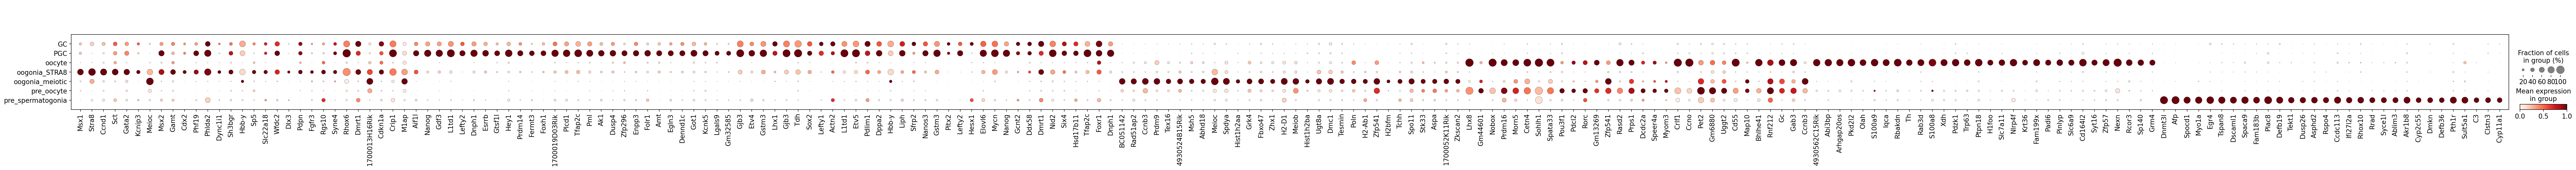

In [20]:
df_tfIDF.to_csv(path_to_gonads + 'mouse-gonads_germcells_TFIDF.tsv', index=False, sep='\t')

sc.pl.dotplot(adataDown, list(topgenes_tfIDF), groupby='celltype', standard_scale = 'var', save='_mouse_germcells_TFIDF.pdf')#topgenes_tfIDF